# Figure S4. Longitudinal effect of age on E-I ratio during adolescence based on session-specific structural connectomes

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
import pickle
import statsmodels.stats.multitest
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)

from utils import transform, plot
from modeling.check_fit import *

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = "#44546A"

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Load data:

In [3]:
itMax = 81
lmbda = 210
params = {
    "G": "0.5-4",
    "wee": "0.05-0.75",
    "wei": "0.05-0.75",
    "wie": "0",
}
het_params = "wee-wei"
n_vols_remove = 13  # ~ 30s: int(30 / 2.2)

elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "imagen_subs_FU2.csv"), index_col=0
).sort_index()
elig_subs_ses = elig_subs.loc[
    np.loadtxt(os.path.join(INPUT_DIR, "imagen_subs_BLnFU2.txt"), dtype=str)
]
parcels = transform.load_ordered_parcel_labels("schaefer-100")

In [4]:
if os.path.exists("imagen_fc-ses_sc-ses_runs-2.csv") & os.path.exists(
    "imagen_fc-ses_sc-ses_runs-2_vars.pkz"
):
    subjects_optima_ses = pd.read_csv("imagen_fc-ses_sc-ses_runs-2.csv", index_col=0)
    with open("imagen_fc-ses_sc-ses_runs-2_vars.pkz", "rb") as f:
        regional_vars_ses = pickle.load(f)
else:
    subjects_optima_ses = []
    regional_vars_ses = {}
    for sub in tqdm(elig_subs_ses.index):
        regional_vars_ses[sub] = {}
        for ses in ["BL", "FU2"]:
            cmaes_dir = os.path.join(
                OUTPUT_DIR["imagen"],
                ses,
                "sim",
                sub,
                f"sc-{ses}_ctx_parc-schaefer-100_mean001_thresh-1",
                "6maps_schaefer-100_zscore",
                "cmaes_multimaps_gpu",
            )
            sims_dir = cmaes_dir.replace("cmaes_multimaps_gpu", "sims_multimaps_gpu")
            sc_path = os.path.join(
                OUTPUT_DIR["imagen"],
                ses,
                "SC",
                sub,
                "ctx_parc-schaefer-100_mean001_thresh-1_desc-strength.txt",
            )
            emp_fc_tril_path = os.path.join(
                OUTPUT_DIR["imagen"],
                ses,
                "FC",
                sub,
                "ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_desc-FCtril.txt",
            )
            emp_fcd_tril_path = emp_fc_tril_path.replace("FCtril", "FCDtril")
            emp_fc_tril = np.loadtxt(emp_fc_tril_path)
            emp_fcd_tril = np.loadtxt(emp_fcd_tril_path)
            regional_vars_ses[sub][ses] = {}
            for SeedMW in [1, 2]:
                cmaes_res = load_cmaes(
                    cmaes_dir,
                    sims_dir,
                    params,
                    het_params,
                    emp_fc_tril,
                    emp_fcd_tril,
                    sc_path=sc_path,
                    n_vols_remove=n_vols_remove,
                    itMax=itMax,
                    lmbda=lmbda,
                    SeedMW=SeedMW,
                    dataset="imagen",
                )
                if cmaes_res:
                    cmaes_res[0]["sub"] = sub
                    cmaes_res[0]["ses"] = ses
                    cmaes_res[0]["SeedMW"] = SeedMW
                    subjects_optima_ses.append(cmaes_res[0])
                    regional_vars_ses[sub][ses][SeedMW] = cmaes_res[1]
    subjects_optima_ses = pd.DataFrame(subjects_optima_ses)
    subjects_optima_ses.to_csv("imagen_fc-ses_sc-ses_runs-2.csv")
    with open("imagen_fc-ses_sc-ses_runs-2_vars.pkz", "wb") as f:
        pickle.dump(regional_vars_ses, f)

Select the best run in each subject-session and add the demographics and motion measures to the data:

In [6]:
subjects_optima_ses[["sex", "site"]] = elig_subs_ses.loc[
    subjects_optima_ses.set_index("sub").index, ["sex", "recruitment centre"]
].values
best_runs = subjects_optima_ses.groupby(["sub", "ses"])["gof"].idxmax().values
data_ses = subjects_optima_ses.loc[best_runs]
data_ses.loc[data_ses["ses"] == "BL", "age"] = elig_subs_ses.loc[
    data_ses.loc[data_ses["ses"] == "BL", "sub"].values, "age_BL"
].values
data_ses.loc[data_ses["ses"] == "FU2", "age"] = elig_subs_ses.loc[
    data_ses.loc[data_ses["ses"] == "FU2", "sub"].values, "age_FU2"
].values
data_ses = data_ses.set_index(["sub", "ses"])

# add motion data
motion_BL = pd.read_csv(
    os.path.join(OUTPUT_DIR["imagen"], "BL", "postfmriprep", "participants.tsv"),
    delimiter="\t",
)
motion_BL["ses"] = "BL"
motion_FU2 = pd.read_csv(
    os.path.join(OUTPUT_DIR["imagen"], "FU2", "postfmriprep", "participants.tsv"),
    delimiter="\t",
)
motion_FU2["ses"] = "FU2"
motion = pd.concat([motion_BL, motion_FU2]).rename(columns={"participant_label": "sub"})
motion_ses = motion.set_index(["sub", "ses"]).loc[data_ses.index]
data_ses = pd.concat([data_ses, motion_ses], axis=1)

Create a dataframe of regional $\langle I^E \rangle$ in each subject:

In [7]:
I_E_ses = pd.DataFrame(index=data_ses.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for idx, row in data_ses.iterrows():
        sub = idx[0]
        ses = idx[1]
        I_E_ses.loc[idx, parc] = regional_vars_ses[sub][ses][row["SeedMW"]].loc[i, "I_E"]

Apply the linear mixed effects model:

In [8]:
df_ses = pd.concat([I_E_ses, data_ses], axis=1)
df_ses.columns = [f"node_{i}" for i in range(100)] + list(df_ses.columns[100:])

t_age_ses = pd.Series(index=parcels)
p_age_ses = pd.Series(index=parcels)
for i, parc in tqdm(enumerate(parcels)):
    # exclude outliers
    curr_subs_BL = (
        I_E_ses.loc[(slice(None), ["BL"]), parc]
        .loc[~(scipy.stats.zscore(I_E_ses.loc[(slice(None), ["BL"]), parc]).abs() >= 3)]
        .index.get_level_values(0)
    )
    curr_subs_FU2 = (
        I_E_ses.loc[(slice(None), ["FU2"]), parc]
        .loc[
            ~(scipy.stats.zscore(I_E_ses.loc[(slice(None), ["FU2"]), parc]).abs() >= 3)
        ]
        .index.get_level_values(0)
    )
    curr_subs = curr_subs_BL.intersection(curr_subs_FU2)
    model_df = df_ses.loc[(curr_subs, slice(None))].reset_index(drop=False)
    # fit the model
    mod = smf.mixedlm(
        f"node_{i} ~ age + gof + sex + mean_rms + site",
        data=model_df,
        groups=model_df["sub"],
    )
    res = mod.fit()
    t_age_ses.loc[parc] = res.tvalues["age"]
    p_age_ses.loc[parc] = res.pvalues["age"]

# FDR correction
_, p_age_fdr_ses = statsmodels.stats.multitest.fdrcorrection(p_age_ses)
p_age_fdr_ses = pd.Series(p_age_fdr_ses, index=parcels)

# save stats and display stats of signficant regions
stats_age_ses = pd.DataFrame({"t": t_age_ses, "p": p_age_ses, "p_fdr": p_age_fdr_ses})
stats_age_ses.to_csv("p_imagen_fc-ses_sc-ses_runs-2_IE_age_stats.csv")
stats_age_ses[stats_age_ses["p_fdr"] < 0.05].sort_values(by="t").round(3)

100it [00:26,  3.82it/s]


,t,p,p_fdr
7Networks_RH_Default_PFCdPFCm_2,-6.558,0.0,0.0
7Networks_RH_Cont_PFCl_3,-6.043,0.0,0.0
7Networks_RH_Cont_Par_2,-5.992,0.0,0.0
7Networks_RH_Cont_Par_1,-5.879,0.0,0.0
7Networks_LH_Cont_Par_1,-5.706,0.0,0.0
...,...,...,...
7Networks_RH_Vis_2,4.422,0.0,0.0
7Networks_RH_SalVentAttn_FrOperIns_1,4.499,0.0,0.0
7Networks_RH_SomMot_2,5.386,0.0,0.0
7Networks_LH_SomMot_2,5.438,0.0,0.0


## A. Effect of age on E-I ratio (FDR-corrected)

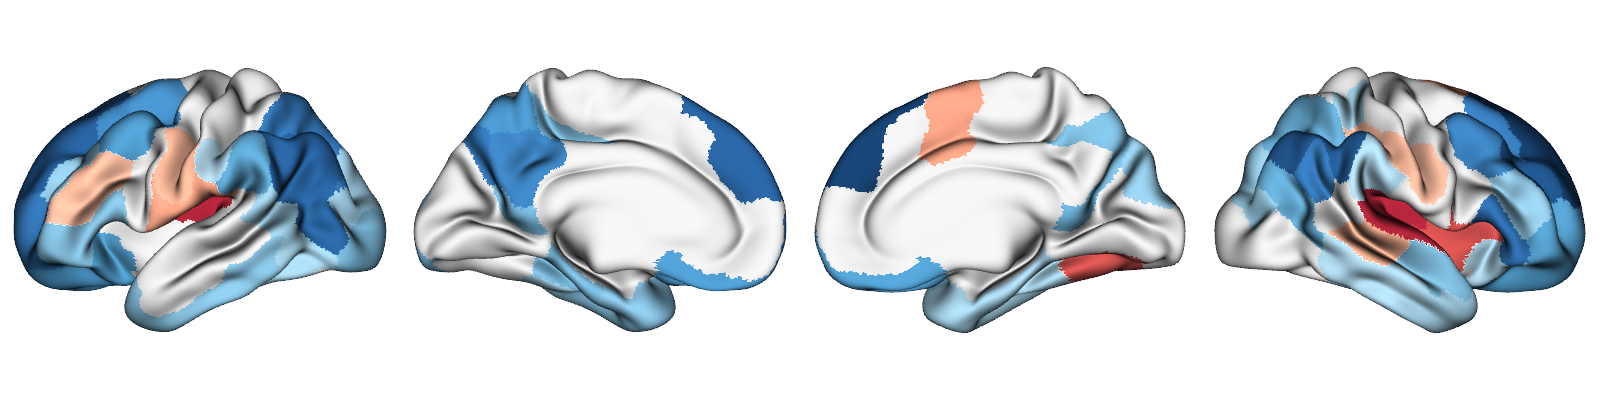

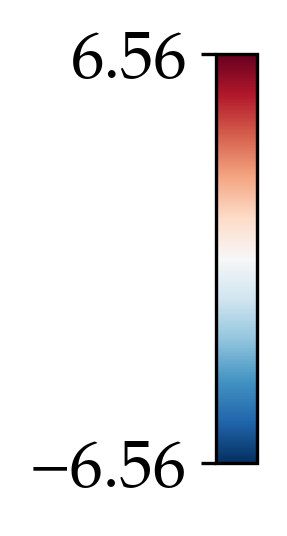

In [9]:
vmin = min(t_age_ses.values.min(), -t_age_ses.values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(
        t_age_ses[p_age_fdr_ses < 0.05], "schaefer-100", concat=True, space="fsaverage"
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style="row",
)

## B. Effect of age on E-I ratio (unthresholded)

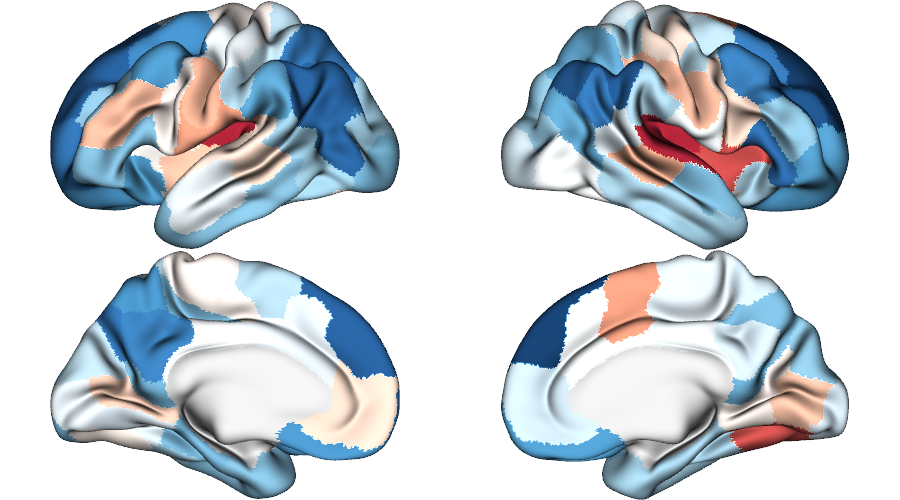

In [10]:
plot.plot_surface(
    transform.deparcellate_surf(
        t_age_ses, "schaefer-100", concat=True, space="fsaverage"
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
)

## C. Correlation with E-I ratio age effects using FU2 SC

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.7791454033089404 ; p-vlaue: 0.0
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.8408267565803855 ; p-vlaue: 0.0


Text(0, 0.5, 'Longitudinal effect of age on E-I ratio\n(follow-up SC)')

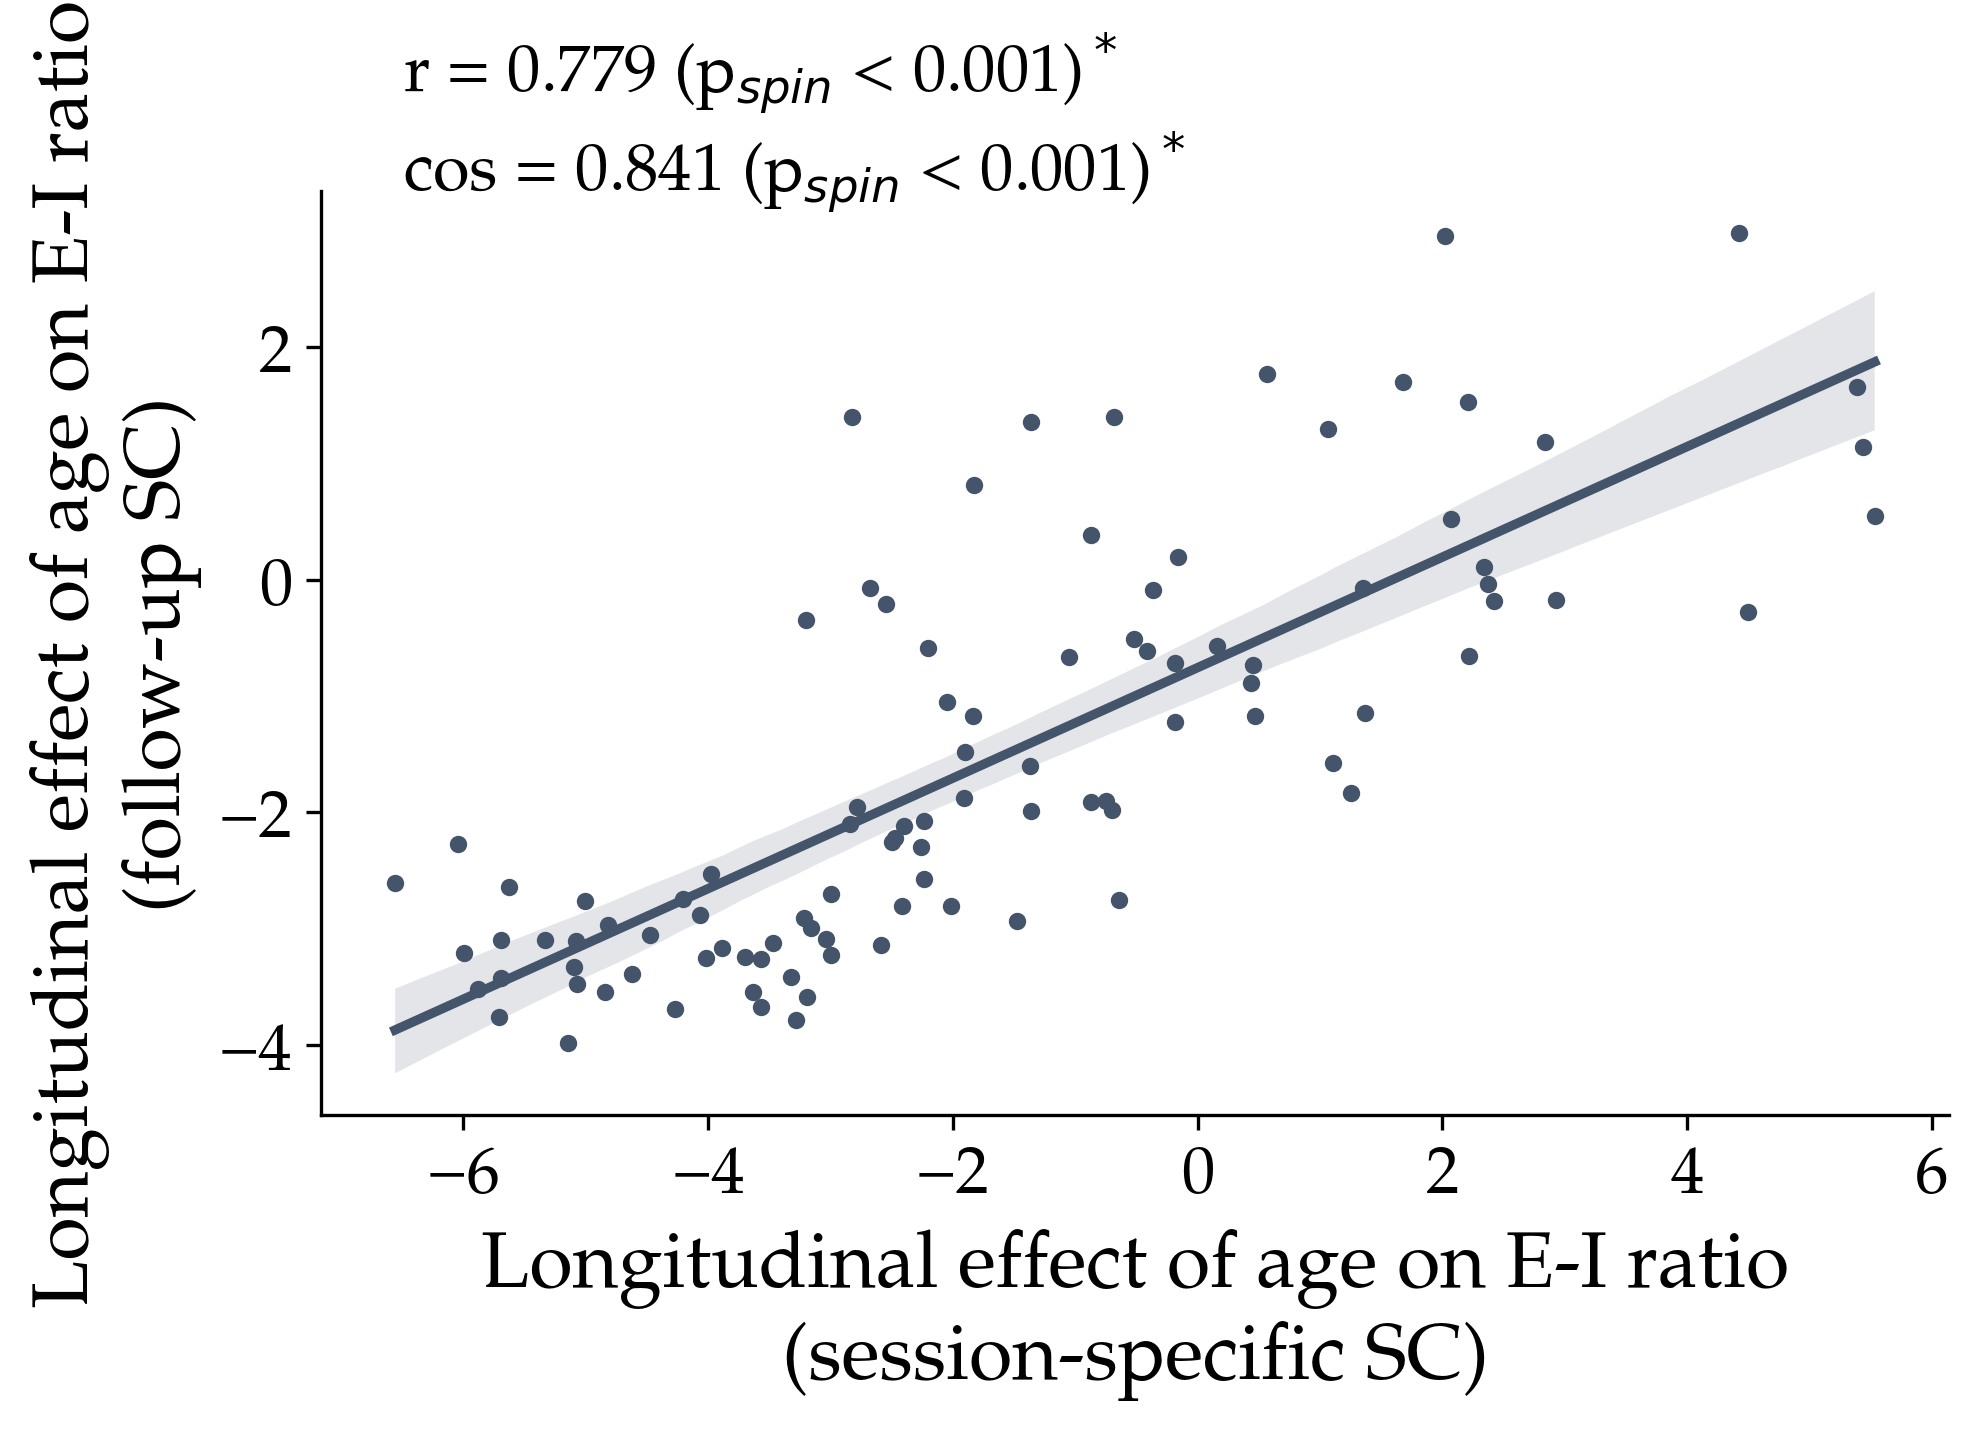

In [14]:
stats_age = pd.read_csv("p_imagen_fc-ses_sc-FU2_runs-2_IE_age_stats.csv", index_col=0)
fig, ax = plt.subplots(figsize=(7, 4))
plot.reg_plot(
    stats_age_ses[["t"]], stats_age[["t"]], "schaefer-100", n_perm=1000, 
    xlabel="Longitudinal effect of age on E-I ratio\n(session-specific SC)",
    ylabel="Longitudinal effect of age on E-I ratio\n(follow-up SC)",
    ax=ax
)
ax.set_xlabel(ax.get_xlabel(), fontsize=19)
ax.set_ylabel(ax.get_ylabel(), fontsize=19)